# Data Mining - Handin 2 - Graph mining

In [28]:
### BEGIN IMPORTS - DO NOT TOUCH!
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
sys.path.append('..')
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install networkx
#!{sys.executable} -m pip install torchvision
import random
import scipy.io as sio
import time

import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import csv
from itertools import count


import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from utilities.load_data import load_mnist
import utilities.email as email
from utilities.mnist import *

from utilities.make_graphs import read_edge_list, read_list, load_data

### END IMPORTS - DO NOT TOUCH!

## Task 1.1 Random walks and PageRank  (12 points)

In this exercise recall that the PageRank is defined as 

$$\mathbf{r} = \alpha \mathbf{Mr} + (1-\alpha)\mathbf{p}$$ 

where $\mathbf{r}\in \mathbb{R}^n$ is the PageRank vector, $\alpha$ is the restart probability, $\mathbf{M} = A\Delta^{-1}$, and $\mathbf{p}$ is the restart (or personalization) vector. 

**************************************
### Task 1.1.1 (4 points)
What is the PageRank of a **$d$-regular** graph with $n$ nodes and $\alpha=1$? 

<span style='color: green'>**\[Motivate\]**</span> your answer without showing the exact computation. 

*************************************
PageRank is the importance of the given node. It is obtained by doing a random walk of the graph and seeing how often it takes us to the given node. This is how each get's assigned a value. The value depends on the weight of the incoming nodes through increasing the probability because we are more likely to end up in a well connected node. By definition d-regular graph each node has d connections. 

The other parameter alpha affects the so called teleport. If the random walk get stuck in a spider trap we would jump to a random node. Here it is not possible to jump since alpha in 1.

All the nodes are equally important so the PageRank of one node is d.
*************************************

### Task 1.2.1 (1 points)

For all graphs $\lambda_0 = 0$ 

*******************
By definition we can find the eigenvalues on a given matrix by the equation $(L-\lambda I)=0$.
These eigenvalues are a solution to the eigenvector $v$ equation that can be written $Lv=\lambda v$. The Laplacian matrix can be is build by:

$L=\begin{cases} deg(n_{ij}) &,\text{if} \; i=j \\ -1 &,\text{if} \; i\neq j \;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

As the degree of a node is the connection is has then the sum of each column and row is 0. There are always as many -1 elements as the degree is. 

Because of this there is always an eigenvector $v_0=(1,1,...,1)$ that corresponds to the eigenvalue $\lambda_0=0$ because these fulfill the eigenvector equation. This is because the right side of the eqution picks out the sum of each row into a vector. 

$L v_0=(0 \; 0 \; 0 ... 0 )^T$

This means that the corresponding eigenvalue is also 0.

$Lv=\lambda v$

$\Rightarrow (0 \; 0 \; 0 ... 0 )^T=(\lambda \; \lambda \; \lambda ... \lambda )^T$

$\Rightarrow \; \lambda = 0$

And as we have chosen the eigenvalues to be ascending it is always with the lowest index.
******************

### Task 1.2.2 (2 points)
For the complete graph, $\lambda_1, \dots, \lambda_{n-1} = n$

******************
A coplete graph is one where all the nodes are connected so it is like this:

$L=\left( \begin{matrix}
n-1 & -1 & \dots & -1 \\
-1 & n-1 & \dots & -1 \\
\vdots & & \ddots & \vdots \\
-1 &  \dots & -1 & n-1
\end{matrix} \right)$

We can find the eigenvalues solving the equation $(L-\lambda I)=0$:

$\left| \left( \begin{matrix}
n-1-\lambda & -1 & \dots & -1 \\
-1 & n-1-\lambda & \dots & -1 \\
\vdots & & \ddots & \vdots \\
-1 &  \dots & -1 & n-1-\lambda
\end{matrix} \right) \right|=0$

Calculating the determinant is simple and can be sone by taking the sub-determinants. As an example in the case $n=3$:

$\left| \left( \begin{matrix}
2-\lambda & -1  & -1 \\
-1 & 2-\lambda & -1 \\
-1 & -1 & 2-\lambda
\end{matrix} \right) \right|=(2-\lambda)((2-\lambda)^2-1)+1(-(2-\lambda)-1))-1((2-\lambda)+1))=0$

$(\lambda -3)^2\lambda = 0$

So as in the previous question we see that the first eigenvalue is 0. The other ones are degenarate. The equation will always come to that form and give that the $\lambda_1, \dots, \lambda_{n-1} = n$ in $n$-dimensional case.

******************

******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

### Task 1.2.5 (6 points)
Suppose that the graph $G$ consists of two connected componentes of equal size named  $G_1$ and $G_2$. For simplicity assume that $n$ is even.<br>
The Laplacian of $G_1$ has eigenvalues $\lambda^1_0,\lambda^1_1,...,\lambda^1_{n/2-1}$.<br>
The Laplacian of $G_2$ has eigenvalues $\lambda^2_0,\lambda^2_1,...,\lambda^2_{n/2-1}$.<br>
Prove that the  Laplacian of $G$ is consisted of the eigenvalues of the Laplacians of $G_1$ and $G_2$ in ascending order.

******************
The $L$ matrix for $G$ looks something like this:

$L=\left( \begin{matrix}
G_1 & E \\
E^T & G_2
\end{matrix} \right)$

Where $G_1$ and $G_2$ are the different components and $E$ is a block consisting of 0's and -1's illustrating how the components are connected to each other.


Beause $G$ is symmetric it can be diagonalizied. This correcsponds to the tarsformation $G=PDP^{-1}$. This tarsformation conserves the eigenvalues beacause they both fulfil the equation:

$G=\lambda I$ 

$=PDP^{-1}\lambda I$

$\Rightarrow D=P^{-1}\lambda I P = \lambda I$


Thus the matrix has the same eigenvalues.


******************

# Part 2: Graphs and Spectral clustering
In this part, you will experiment and reflect on spectral clustering as a technique for partitioning a graph. 

### Task 2.1.3 (2 points)
Assign to each edge in the $\varepsilon$-neighborhood graph a weight

$$W_{i j}=e^{-\frac{\left\|\mathbf{x}_{i}-\mathbf{x}_{j}\right\|^{2}}{t}}$$

<span style='color: green'>**\[Implement\]**</span> the function ```weighted_nn_graph``` below that returns the weighted graph given the data matrix in input and the values eps and $t$, where $t$ is the parameter of the equation above. 

In [13]:
import math

def weighted_nn_graph(data, eps=20, t=0.1):
    n = len(data)
    G = nx.Graph()
    ### YOUR CODE STARTS HERE
    
    for i in data:
        for j in data:
            d= (i[0]-j[0])**2+(i[1]-j[1])**2
            if (d!=0 and d<eps**2):
                G[i][j]['weight']=math.e**(-d/t)
            else:
                G[i][j]['weight']=0
    
    ### YOUR CODE ENDS HERE
    return G

### Task 2.1.4 (2 points)

Vary $t \in \{10, 0.1, 0.000001\}$. Plot the weights as a histogram using the code below in order to analyse the results using the provided code.</br>
What happens when $t$ is very small, close to $0$, i.e., $t \rightarrow 0$?</br> What happens when $t$ is very large?
</br>Is the behaviour with $t = 0$ expected?

<span style='color: green'>**\[Motivate\]**</span> your answer reasoning on the formula. 

TypeError: unhashable type: 'numpy.ndarray'

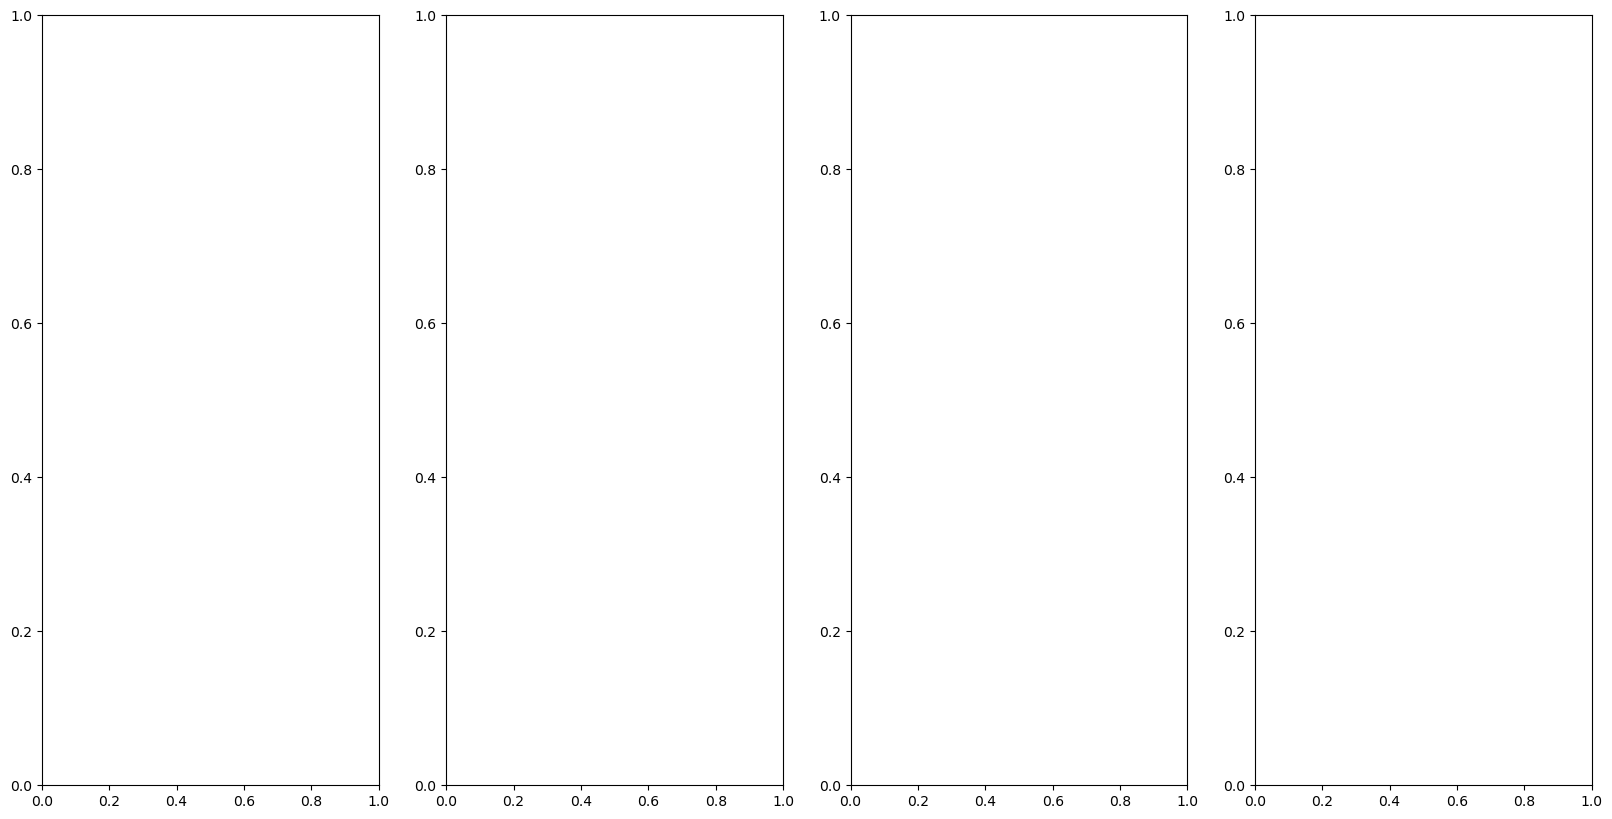

In [34]:
ts = [10, 0.2, 0.07, 0.000001]
fig, ax = plt.subplots(1,4, figsize=(20, 10))
row = 0

for i, t in enumerate(ts):
    G = weighted_nn_graph(X, eps=60, t=t)
    ys = []
    

    col = i 
    for i, d in enumerate(G.edges.data()):
        ys.append(d[2]['weight'])
    plt.hist(ys, bins=100)
    ax[col].hist(ys, bins=100)
    ax[col].set_title("t: "+str(t))
    
plt.tight_layout()

******************
When $t$ is very small, close to $0$, i.e., $t \rightarrow 0$ the weight get's smaller and smaller. This due to the definition of the weight. Because it's defined as exponential dampening. The L2-norm is always non-negative and the smaller t produces bigger and bigger exponents.

When $t$ is very large the weights are also bigger due to the exponents being smaller.

This is something we expected from the formula and also see in the plots.

******************

## Task 2.2: Spectral clustering (20 points)

We will now look at spectral clustering and its properties. <br>
For this Task we will use a subgraph from [malaria_genes](https://networks.skewed.de/net/malaria_genes). <br>
Note that this dataset is the biological network of the data used in Task 2.1. <br>

### Task 2.2.1 (5 point)
Run the code below to load and visualize the network. <br> 
By only observing the below plot and the $nn$-plots (nearest-neighbor plots)of task 2.1.2, which $\varepsilon$ values seems to better approximate the real network? (just think of the answer you don't have to write something)

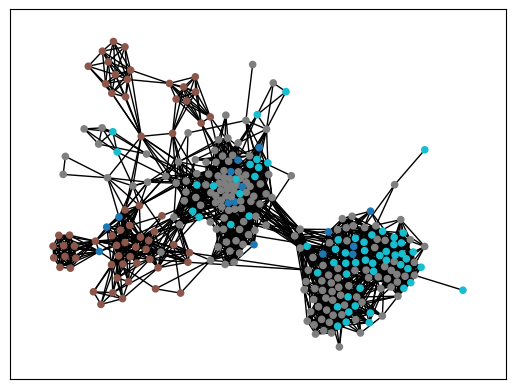

In [65]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for edge in edgelist:
    G.add_edge(edge[0], edge[1])
pos=nx.spring_layout(G)  
nx.draw_networkx_edges(G,pos=X)
nx.draw_networkx_nodes(G, pos=X, node_color=Y, node_size=20, cmap=plt.get_cmap('tab10'))
plt.show()

Now you are having the real network, lets check how good $nn$-graph (and for which $\epsilon$ value) is a good "approximates"the real graph. <br> 

A) <span style='color: green'>**\[Implement\]**</span> a function that calculates the absolute edge difference between the real network $G$ and the one $\epsilon$-neighborhood graph. Note that in order to do that you have to follow two steps: 
1. In the first step you have to check if an edge in the real graph is also presented in the $nn$-graph, if not you increase the counter
2. In the second step you follow the opposite direction, that is you check if for every edge of the $nn$-graph if is also presented in the original one, if not you increase the counter. (Faster way just use the adjacency matrices) <br>

B) <span style='color: green'>**\[Implement\]**</span> Plot the edge-difference plot for the range of epsilon values in the range[0.01, 0.11] with step = 0.005. <br>
C) <span style='color: green'>**\[Motivate]**</span> By observing the plot it seems that there exists only one global minimum and no local minimum. Try to prove/disprove this intuition.

In [38]:
#A) YOUR CODE HERE
#Here the epsilon has to be adjusted some. 
#I'm thinking of maybe a good value might be something close to the diameter of the average clusters above
def difference(data, eps):
    counter = 0
    for edge in G.edges():
        if edge in nn_graph(data, eps, remove_self=True, directed=False):
            counter += 1
    for edge in nn_graph(data, eps, remove_self=True, directed=False).edges():
        if edge in G:
            counter += 1
    return counter
    print("The absolute difference of the edges is " + repr(counter))

difference(X, 0.1)

NameError: name 'distance_matrix' is not defined

In [37]:
#B) YOUR CODE HERE

points = np.array([])
initial = 0.01

while eps<= 0.11:
    dif = difference(X, eps)
    plt.scatter(eps,dif)
    eps+=0.005

plt.show()

NameError: name 'distance_matrix' is not defined

******************
C) This intuition of one global and no local minimum makes sense. As we are plotting the difference of the edges as a function of epsilon there must be one epsilon value (or close to one) that produces the most similar one. Moving away from that value would always increase the difference of the edges. There is also no local minumums since this method is based on the L2-norm in epsilon neighbourhoods. It's basically a linear dependancy is imagining it in radial coordinates.
******************

### Task 2.2.2 (2 points)
Compute the eigenvectors and eigenvalues (using the provided function) of the Normalized Laplacian and the Random Walk Laplacian of the graph $G$.<br> 
Plot the spectrum (eigenvalues).

<span style='color: green'>**\[Implement\]**</span> the code to compute the different Laplacians. 

In [39]:
def graph_eig(L): 
    """
        Takes a graph Laplacian and returns sorted the eigenvalues and vectors.
    """
    lambdas, eigenvectors = np.linalg.eig(L)
    lambdas = np.real(lambdas)
    eigenvectors = np.real(eigenvectors)
    
    order = np.argsort(lambdas)
    lambdas = lambdas[order]
    eigenvectors = eigenvectors[:, order]
    
    return lambdas, eigenvectors

In [40]:
L_norm = None
L_rw = None

### YOUR CODE STARTS HERE

##The eigenvalue takes a matrix eg array of array


for i in X:
    nrow = []
    rwrow = []
    for j in X:
        ie = G.edges(X[i])
        je = G.edges(X[j])
        if i==j:
            nrow.append(1)
            rwrow.append(1)
        if (i!=j and X.has_edge(X[i],X[j])==true):
            nrow.append(-1/math.sqrt(ie*je))
            rwrow.append(-1/ie)
        else:
            nrow.append(0)
            rwrow.append(0)
            
    L_norm.append(nrow)
    L_rw.append(rwrow)
            


### YOUR CODE ENDS HERE

eigval_norm, eigvec_norm = graph_eig(L_norm)
eigval_rw, eigvec_rw = graph_eig(L_rw)

plt.figure(0)
plt.plot(eigval_norm, 'b-o', label='Spectrum of Normalized Laplacian', )
plt.legend()
plt.figure(1)
plt.plot(eigval_rw, 'b-o', label='Spectrum of the Random Walk Laplacian')
plt.legend()

TypeError: only integer scalar arrays can be converted to a scalar index

These definations of the matrices are from wikipedia. IWe're using these ones: 

$L_{norm}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{\sqrt{deg(v_i)(v_j)}} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

$L_{rw}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{deg(v_i)} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

### Task 2.2.3 (4 points)
<span style='color: green'>**\[Implement\]**</span> the function ```spect_cluster``` that returns a vector ```y_clust``` in which each entry y_clust\[i\] represents the community assigned to node $i$. The method should be able to handle both the Normalized Laplacian, and the Random Walk Laplacian. You are allowed to use your implementation from the weekly exercises and ```sklearn.cluster.k_means``` for k-means clustering. 

In [43]:
from sklearn.cluster import k_means

def spect_cluster(G, eig_type="normal", k=5, d=5):
    ### YOUR CODE STARTS HERE
    km = k_means(k,d)
    km.fit(G)
    
    y_clust = km.labels_

    ### YOUR CODE ENDS HERE
    return y_clust #vector

In [44]:
def plot_graph(G, clusters):
    plt.figure(1,figsize=(30,15))
    nodes = G.nodes()
    ec = nx.draw_networkx_edges(G, X, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, X, nodelist=nodes, node_color=clusters, node_size=100, cmap=plt.cm.jet)

    plt.axis('off')
    plt.show()

your_clusters = spect_cluster(G, k=6)   
plot_graph(G, your_clusters)


ValueError: Expected 2D array, got scalar array instead:
array=6.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Task 2.2.4 (1 points)

Finally, use your implementation of spectral clustering with different Laplacians and different values of $k \in [2,7]$ and plot the results using the helper function ```plot_graph```. 

<span style='color: green'>**\[Describe\]**</span> the results you obtain. Especially, what is the difference between the Random Walk and the Normalized Laplacians, if any? How do you explain such differences? 

In [45]:
for method in ['normal', 'random']: 
    for k in np.arange(2,8): 
        your_clusters = spect_cluster(G,eig_type=method, k=k)
        plot_graph(G, your_clusters)

ValueError: Expected 2D array, got scalar array instead:
array=2.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

******************
The differences between random walk and normalized Laplacians arise from the sums of the rows/colums. As seen with the definition the random walk Laplacian sum of each row is 0. This is not true for the normalized. This results the distances to be slighty smaller on the normalized data and such the characteristics of clusters are need more fine tuning. 
******************

# Part 3: Link analysis
In this exercise, we will work with PageRank, Random Walks and their relationships with graph properties. 
We will use the most generic definition

$$\mathbf{r} = \alpha \mathbf{Mr} + (1-\alpha)\mathbf{p}$$

with $\mathbf{r}$ the PageRank vector, $\mathbf{M}$ the weighted transition matrix, and $\mathbf{p}$ the personalization vector. 
Additionally, let $n = |V|$, where $V$ is the nodes in the graph above.
Remember that in the case of PageRank the entries of the personalization vector are $p_i = 1/n$ for all $i$.  


## Task 3.1 Approximate PageRank (10 points)

### Task 3.1.1 (3 points)

<span style='color: green'>**\[Implement\]**</span>  a different algorithm for computing Personalized PageRank. This algorithm runs a fixed number of iterations and uses the definition of random walks. 
At each step, the algorithm either selects a random neighbor with probability $\alpha$ or returns to the starting node with probability $1-\alpha$. Every time a node is visited a counter on the node is incremented by one. Initially, each counter is 0. The final ppr value is the values in the nodes divided by the number of iterations. 

In [125]:
import random
def approx_personalized_pagerank(G, node, alpha = 0.85, iterations = 1000): 
    ppr = np.zeros(G.number_of_nodes())
    ### YOUR CODE STARTS HERE
    next = node
    nn= G.number_of_nodes()-1
    
    for i in range(iterations):
        prob = random.randint(0,100)/100
        if (prob<alpha): #See if we should go to neighbour or jump
            nneigh = []
            for edge in edgelist: #let's find out where we can jump
                if (edge[0]==next):
                    nneigh.append(edge[1])
            if (len(nneigh)==0): #we should jump if there are no neighbours
                j = random.randint(0,nn) #Choose the index of a next node from the whole set
                ppr[j]+=1 #count the jump
                next = j #G[j]
                continue
            j = random.randint(0,len(nneigh)-1) #Choose the index of a next node of neighbours
            next = nneigh[j]
            ppr[next]+=1 #count the jump
            node = j #G[next] 
        else: #if we jump
            j = random.randint(0,nn) #Choose the index of a next node from the whole set
            ppr[j]+=1 #count the jump
            next = j #G[j] 
    ### YOUR CODE ENDS HERE
    return ppr

### Task 3.1.2 (3 points)

Run the ```approx_personalized_pagerank``` with default $\alpha$ and iterations $\{10, n, 2n, 4n, 100n, 1000n\}$ where $n$ is the number of nodes in the graph and starting node the node with the highest PageRank computed in Task 3.1.2.

<span style='color: green'>**\[Motivate\]**</span> what you notice as the number of iterations increase. Why are the values and the top-10 nodes ranked by PPR changing so much? 

In [126]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for edge in edgelist:
    G.add_edge(edge[0], edge[1])
starting_node = np.argmax(nx.pagerank(G))
for i, iterations in enumerate([10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100, G.number_of_nodes()*1000]):
    r = approx_personalized_pagerank(G, starting_node, iterations = iterations)
    r[starting_node] = 0
    r_sorted = np.argsort(r)[::-1]
    r_values = np.sort(r)[::-1]
    print(f'Iteration {iterations}: top-10 r={r_sorted[:10]}\n top-10 values={r_values[:10]}\n')

import operator
rr = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
rr[starting_node] = 0
r=np.zeros(len(rr))
for k in rr: r[k] = rr[k]
r_sorted = np.argsort(r)[::-1]
r_values = np.sort(r)[::-1]
print(f'top-10 r={r_sorted[:10]}\n top-10 values={r_values[:10]}\n')

Iteration 10: top-10 r=[225 137  42 178  57 287 288 289 291  40]
 top-10 values=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Iteration 307: top-10 r=[306 305 292 291 287 293 290 304 303 288]
 top-10 values=[16. 12. 12.  8.  7.  6.  6.  5.  5.  5.]

Iteration 614: top-10 r=[306 292 291 289 290 240 287 243 305 293]
 top-10 values=[29. 25. 18. 13. 12. 11. 11. 10. 10.  9.]

Iteration 1228: top-10 r=[306 292 291 293 305 239 287 290 240 288]
 top-10 values=[61. 60. 33. 25. 25. 23. 23. 22. 19. 19.]

Iteration 30700: top-10 r=[306 292 305 291 287 293 290 289 244 240]
 top-10 values=[1551. 1226.  774.  679.  582.  498.  457.  449.  422.  411.]



KeyboardInterrupt: 

******************
The frequency of the nodes start to get bit closer together. To this 10 iterations is different. For example the spread of frequencies in 307 is wider than for 307000. It also seems like the same nodes are often visited in the iterations. That makes sense since nodes that have a lot of neighbours are more probable to be chosen. 

There is a lot of variation between the rankes. When the nuber if iterations is very small the probabilistic nature of the method doesn't show. It's like tossing a coin once and concluding that the only option is the one you get. 
The bigger the number of iterations gives a more average solution for the ranks.
******************

### Task 3.1.3 (2 points)

Compare the 5 nodes with the highest PPR obtained from ```nx.pagerank(G, alpha=0.85, personalization={node_highest_pagerank: 1})``` and the one obtained by the approximation. 

<span style='color: green'>**\[Describe\]**</span> the differences. Does the number of iterations affect the results? Is there a relationship between the number of iterations and the results? Is there a relationship between the approximated value of PageRank and the real value? Do you notice anything as the number of iteration increases? 

In [106]:
k = 5
ppr_nx = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
r_nx = [0 for _ in range(G.number_of_nodes())]
for k, v in ppr_nx.items():
    r_nx[k] = v
r_est = approx_personalized_pagerank(G, starting_node, alpha=0.85)

topk_nx = np.argsort(r_nx)[-5:]
topk_est = np.argsort(r_est)[-5:]

print(topk_nx, topk_est)

for iterations in [10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100, G.number_of_nodes()*1000]:
    print(f'Number of iterations {iterations}')
    ppr_nx = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
    r_nx = [0 for _ in range(G.number_of_nodes())]
    for k, v in ppr_nx.items():
        r_nx[k] = v
    r_est = approx_personalized_pagerank(G, starting_node, iterations = iterations, alpha=0.85)
    print(f'Approximate PPR: {r_est[:10]}')
    print(f'Real PPR: {r_nx[:10]}')
    
    
    topk_nx = np.argsort(r_nx)[-5:]
    topk_est = np.argsort(r_est)[-5:]

    print(f"Topk of nx.pagerank: {topk_nx}, Topk of our estimation {topk_est}, Size of intersection: {len(set(topk_nx).intersection(set(topk_est)))}")

[18 41 40 39  0] [4 2 3 1 0]
Number of iterations 10
Approximate PPR: [2. 2. 0. 0. 0. 0. 2. 0. 0. 0.]
Real PPR: [0.20102640550640022, 0.0004761511237216732, 0.001421044532107968, 0.00517928011352294, 0.0010162923813859888, 0.0006924636204434976, 0.000586579792176299, 0.000586579792176299, 0.0003234474438257967, 0.00019090839324436927]
Topk of nx.pagerank: [18 41 40 39  0], Topk of our estimation [ 36 115   6   1   0], Size of intersection: 1
Number of iterations 307
Approximate PPR: [49. 38. 29. 26. 18. 11. 15. 10. 14.  7.]
Real PPR: [0.20102640550640022, 0.0004761511237216732, 0.001421044532107968, 0.00517928011352294, 0.0010162923813859888, 0.0006924636204434976, 0.000586579792176299, 0.000586579792176299, 0.0003234474438257967, 0.00019090839324436927]
Topk of nx.pagerank: [18 41 40 39  0], Topk of our estimation [4 3 2 1 0], Size of intersection: 1
Number of iterations 614
Approximate PPR: [48. 44. 34. 21. 18. 16. 22. 11.  8.  7.]
Real PPR: [0.20102640550640022, 0.000476151123721673

*****************
It would seem that our method has some mistake left. Even by normalizing with the number of nodes the order of magniude isn't quite correct. Compared to the real one the approximate ones seem to be much closer and even. In the real one the first one seems to be quite large compared to the later ones. IT would seem that the bigger the number of iterations closet to the real one we get.
*****************

### Task 3.1.4 (2 points)

Run again the same experiment but this time use $\alpha = 0.1$. 

<span style='color: green'>**\[Motivate\]**</span> Motivate whether and why you need more or less iterations to predict the 5 nodes with the highest PPR.

In [107]:
for iterations in [10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100]:
    ppr_nx = nx.pagerank(G, alpha=0.1, personalization = {starting_node: 1})
    r_nx = [0 for _ in range(G.number_of_nodes())]
    for k, v in ppr_nx.items():
        r_nx[k] = v
    r_est = approx_personalized_pagerank(G, starting_node, iterations = iterations, alpha=0.1)

    topk_nx = np.argsort(r_nx)[-5:]
    topk_est = np.argsort(r_est)[-5:]

    print(f"Topk of nx.pagerank: {topk_nx}, Topk of our estimation {topk_est}, Size of intersection: {len(set(topk_nx).intersection(set(topk_est)))}")
    

Topk of nx.pagerank: [40 41 42 39  0], Topk of our estimation [253 252 127 154 224], Size of intersection: 0
Topk of nx.pagerank: [40 41 42 39  0], Topk of our estimation [117  55   2   4   0], Size of intersection: 1
Topk of nx.pagerank: [40 41 42 39  0], Topk of our estimation [  2  64  73 174   0], Size of intersection: 1
Topk of nx.pagerank: [40 41 42 39  0], Topk of our estimation [23 38 10  3  0], Size of intersection: 1
Topk of nx.pagerank: [40 41 42 39  0], Topk of our estimation [215  68  78 259  39], Size of intersection: 1


*****************
It would seems that method is able to catch some of the most visited nodes. It's very apparent that 10 is way too few for this data set. In this instance  the bigger iterations don't have that much difference between them. It looks that after a certain point more iterations doesn't give better results but just takes longer. So as long as the number of iterations is greater than the number of nodes the method gives a good enough approximation.
*****************

## Task 3.2 Spam and link farms (12 points)

We will now study the effect of spam in the network and construct a link farm. In this part, if you want to modify the graph, use a copy of the original graph every time you run your code, so that you do not keep adding modifications.

In [108]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G2 = nx.Graph()
for i in range(n):
    G2.add_node(i)
for edge in edgelist:
    G2.add_edge(edge[0], edge[1])
G = G2.copy()

### Task 3.2.1 (3 points)
Based on the analysis in the slides, construct a spam farm $s$ on the graph $G$ with $T$ fake nodes. Assume that $s$ manages to get links from node 1. With $\alpha=0.5$, 

<span style='color: green'>**\[Describe\]**</span> which is the minimum number of pages $T$ that we you need to add in order to get $s$ being assigned the highest PageRank?

******************
As aplha in 0.5 in half of the cases we move on to a neighbour and in half teleport. As a general principle you the highest PageRank is the node that has the most connection so T should be so that the desired node gets the biggest value. Sometimes the value doesn't have to be as big is the node already has good connections. If it's neighbour nodes are well connected T can be smaller than for a node thats neighbours have very few connections.
******************

### Task 3.2.2 (3 points)
In the above scenario, assume that $T = \frac{1}{5}$ of the nodes in the original graph. 

<span style='color: green'>**\[Motivate\]**</span> what value of $\alpha$ will maximize the PageRank $\mathbf{r}_s$ of the link farm $s$. Provide sufficient justification for your choice.

******************
A good choice would be quite a large alpha. As the fake nodes are connected to the one node s have none other edges you would end up visiting the central node s quite often. Large alpha would mean that it was more like to get more stuck in those fake edges. Large alpha means that it is more likely to jump to a neighbour node. With a small alpha there would be a lot of teleporting. That means that the node s wouldn't gain any extra probablity for the fake nodes.
******************

### Task 3.2.3 (3 points)

Now we fix both $\alpha = 0.5$ and $T = \frac{1}{5}n$. 

<span style='color: green'>**\[Implement\]**</span>  ```trusted_pagerank``` the method for spam mass estimation.

In [141]:
def trusted_pagerank(G, trusted_indices, iterations=500, alpha=0.5):
    r = None   
    ### YOUR CODE STARTS HERE
    rplus = np.zeros(G.number_of_nodes())
    next = 0
    k = random.randint(0,G.number_of_nodes()-1)
    nn = trusted_indices.number_of_nodes()-1
    
    rank = approx_personalized_pagerank(G, 0, alpha, iterations) #Get the page rank of every node
    
    for i in range(iterations): #get the pagerank when just jumping to trusted nodes
        next = random.randint(0,nn) #Choose the index of a next node from the whole set
        rplus[next]+=1 #count the jump
        node = trusted_indices[next]
            
    for i in range(len(G)):
        r[i]=(rank[i]-rplus[i])/rank[i]
    
    ### YOUR CODE ENDS HERE
    return r


### Task 3.2.4 (3 points)

<span style='color: green'>**\[Motivate\]**</span> whether we are able to detect the node $s$, if the trusted set of nodes is a random sample $10\%$ of the nodes in the original graph. 
If not, what could be a viable solution? Which nodes would you rather choose as trusted?

You are not obliged to, but you can write some helper code to reach the answer faster.  

_Hint_: Remember the spam mass formula in the Link Analysis lecture

*******************
In the solution we used the spam mass to estimate if page could be trusted. We would of course have to set some limit of what a trusted value would be. Anything with too high mass would be labeled as spam. You could also choose some deviation from a trusted value and anything that differs too much from it would be labeled as spam. 
******************